In [1]:
import os
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"
import numpy as np
import pandas as pd
from pyscf import lib, gto, scf
import pyqmc
import h5py

This function computes the mean-field solution and saves the results to the file specified.

In [2]:
def mean_field(chkfile):
    mol = gto.M(atom = "He 0. 0. 0.", basis='bfd_vdz', ecp='bfd', unit='bohr')

    mf = scf.RHF(mol)
    mf.chkfile = chkfile
    mf.kernel()
    return mol, mf

Set up our wave function given a molecule and mean-field object

In [3]:
def qmcwf(mol, mf):
    jast, to_optj, freezej = pyqmc.default_jastrow(mol)
    slater = pyqmc.PySCFSlaterUHF(mol, mf)
    wf = pyqmc.MultiplyWF(slater,jast)
    freeze = {}
    for k in to_optj:
        freeze["wf2" + k] = freezej[k]
    to_opt = ["wf2" + x for x in to_optj]
    return wf, to_opt, freeze
    


This function runs VMC, recovering the mean-field objects from `chkfile`. These could be run in completely different processes.

If `hdffile` exists, then the configurations will be reloaded from it and the run will be continued. You can run this as many times as you like and the statistics will get better.

In [4]:
def runvmc(chkfile, wffile, hdffile):
    #recover the mean-field objects
    mol = lib.chkfile.load_mol(chkfile)
    mf = scf.RHF(mol)
    mf.__dict__.update(scf.chkfile.load(chkfile, 'scf'))

    #Set up our MC variables and wave function
    wf, _, _ = qmcwf(mol,mf)
    hdf = h5py.File(wffile, 'r')
    grp = hdf['wf']
    for k in grp.keys():
        wf.parameters[k] = np.array(grp[k])

    accumulators = {'energy': pyqmc.EnergyAccumulator(mol) } 
    #This will get 
    configs = pyqmc.initial_guess(mol, 1000)
    hdf = h5py.File(hdffile,'a')

    pyqmc.vmc(wf, configs, accumulators=accumulators, hdf_file = hdf)


In [5]:
def optimize(chkfile, wffile):
    #recover the mean-field objects
    mol = lib.chkfile.load_mol(chkfile)
    mf = scf.RHF(mol)
    mf.__dict__.update(scf.chkfile.load(chkfile, 'scf'))
    wf, to_opt, freeze = qmcwf(mol, mf)
    accumulator = pyqmc.gradient_generator(mol, wf,to_opt, freeze)
    coords = pyqmc.initial_guess(mol, 1000)
    hdf = h5py.File(wffile, 'a')
    wf, df = pyqmc.line_minimization(wf,coords, accumulator, hdf_file = hdf)


A simple analysis script to check on the progress of your calculation.

In [6]:
def analyze(hdffile):
    hdf = h5py.File(hdffile, 'r')
    energy = np.array(hdf['energytotal'])
    for nb in [50, 20, 10]:
        reblock = pyqmc.avg_reblock(energy, nb)

        print(nb, np.mean(reblock), np.std(reblock)/np.sqrt(len(reblock)) )


Here we run the mean-field calculation. It's a good idea to run analyze() to make sure that the solution is similar to what you would expect. 

In [7]:
chkfile = 'he.chk'
hdffile = 'he.hdf5'
wffile = "savewf.hdf5"

#This is so we can start over each time we run!
#Don't do this if you want to save your data.
for filenm in [chkfile, hdffile, wffile]:
    if os.path.isfile(filenm):
        os.remove(filenm)
        
mol, mf = mean_field(chkfile)
mf.analyze()

converged SCF energy = -2.86193223020366
**** MO energy ****
MO #1   energy= -0.917801424375274 occ= 2
MO #2   energy= 0.727613019225335  occ= 0
MO #3   energy= 0.727613019225335  occ= 0
MO #4   energy= 0.727613019225338  occ= 0
MO #5   energy= 1.58197375047964   occ= 0
 ** Mulliken atomic charges  **
charge of  0He =      0.00000
Dipole moment(X, Y, Z, Debye):  0.00000,  0.00000,  0.00000


((array([1.99999047e+00, 9.53120630e-06, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00]), array([2.22044605e-16])), array([0., 0., 0.]))

We can now run VMC on our Slater-Jastrow wave function. Each time we run it, the error bars will decrease.


In [8]:
optimize(chkfile, wffile)

starting warmup
warmup finished, nsteps 100
descent en -2.874478317704893 0.0013387856116458881
descent |grad| 0.16213539535634486
descent step -0.04           -2.874432221    weight stddev 0.01785559781  
descent step 0.02            -2.884869054    weight stddev 0.008800806197 
descent step 0.08            -2.892671841    weight stddev 0.03474439732  
descent step 0.14            -2.898043025    weight stddev 0.06008089614  
descent step 0.2             -2.901171511    weight stddev 0.08490832791  
polynomial fit [ 0.33825987 -0.16520916 -2.88162113]
estimated minimum 0.2442044965681123
estimated minimum adjusted 0.2
descent en -2.8939966436738707 0.0006679068615095764
descent |grad| 0.040418646659449824
descent step -0.04           -2.8839169      weight stddev 0.003692807767 
descent step 0.02            -2.885400236    weight stddev 0.001876257204 
descent step 0.08            -2.886784889    weight stddev 0.007626829229 
descent step 0.14            -2.888072005    weight stddev 

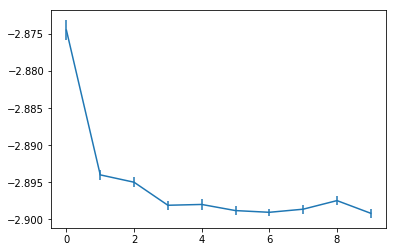

In [9]:
hdf = h5py.File(wffile,'r')
import matplotlib.pyplot as plt
%matplotlib inline
plt.errorbar(hdf['iteration'], hdf['energy'], hdf['energy_error'])
hdf.close()

starting warmup
warmup finished, nsteps 100
descent en -2.8992176672170236 0.0005343740028032838
descent |grad| 0.010177199171632458
descent step -0.04           -2.887486516    weight stddev 0.0005138938735
descent step 0.02            -2.887374456    weight stddev 0.0002583689356
descent step 0.08            -2.887260405    weight stddev 0.001039196458 
descent step 0.14            -2.887144364    weight stddev 0.001828662654 
descent step 0.2             -2.887026335    weight stddev 0.002626842063 
polynomial fit [ 2.76390435e-04  1.87320202e-03 -2.88741203e+00]
estimated minimum -3.388688213617738
estimated minimum adjusted -0.04
descent en -2.8994960618512278 0.0006739617919577233
descent |grad| 0.010603990390630815
descent step -0.04           -2.895443478    weight stddev 0.0005361522636
descent step 0.02            -2.895187832    weight stddev 0.0002696900698
descent step 0.08            -2.894930329    weight stddev 0.001085256626 
descent step 0.14            -2.89467097   

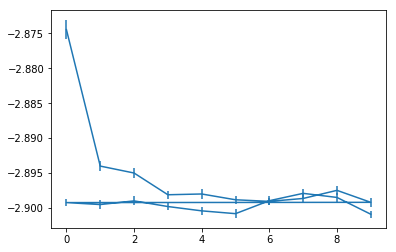

In [10]:
optimize(chkfile, wffile)
hdf = h5py.File(wffile,'r')
import matplotlib.pyplot as plt
%matplotlib inline
plt.errorbar(hdf['iteration'], hdf['energy'], hdf['energy_error'])
hdf.close()

In [11]:
runvmc(chkfile, wffile, hdffile)
analyze(hdffile)

50 -2.8974166 0.002016813102285727
20 -2.8974166 0.0028629374641120637
10 -2.8974166 0.0030828988827858094


In [12]:
runvmc(chkfile, wffile, hdffile)
analyze(hdffile)

50 -2.8996148 0.0014390568589088034
20 -2.8996148 0.0016853385690961916
10 -2.8996148 0.0017975677565666042
